# Multi-stocks analysis using clustring for GICS sectors

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import argparse
from datetime import datetime
from utils import *
from get_tickers import *
from factors_lib import *

# Construct the info Dataframe

In [2]:
stock_tickers_info = get_sp500_stockinfo_df()
tickers_list = list(stock_tickers_info['Symbol'])
sector_list = list(stock_tickers_info['GICS Sector'])


all_data_df = None
for ticker in tickers_list:
    try:
        start = "2024-07-01"
        stock_data = yf.download(ticker, start=start, end=datetime.today())
        stock_data['CotractId'] = ticker
        stock_data['Sector'] = sector_list[tickers_list.index(ticker)]
        # stock_data['Date'] = pd.to_datetime(stock_data.index)
        stock_data["OpenPrice"] = stock_data["Open"]
        stock_data["ClosePrice"] = stock_data["Close"]
        stock_data["LowPrice"] = stock_data["Low"]
        stock_data["HighPrice"] = stock_data["High"]
        stock_data["Return"] = (stock_data["ClosePrice"] - stock_data["ClosePrice"].values[0])/ stock_data["ClosePrice"].values[0] * 100
        stock_data["Return"] = stock_data["Return"].copy().shift(-1).fillna(0)
        # prepare for factors
        stock_data["STR"] = Short_Term_Reversion(df=stock_data, cal_choose="Close", n_days=5).fillna(0)
        stock_data["FRX"] = ForceIndex(pool_df=stock_data)
        stock_data["OSS"] = Oversold_Reverse_Score(df=stock_data)
        stock_data["CCG"] = CCG_Score(stock_data)
        stock_data["ILLIQ"] = ILLIQ_Factor(stock_data, 9)

        # standardlise data
        feature_list = ['OpenPrice', 'ClosePrice', 'LowPrice', 'HighPrice','Volume', 'STR', 'FRX', 'OSS', 'CCG', 'ILLIQ']
        stock_data[feature_list], _ = standardize_training_data(stock_data, feature_list)

        if all_data_df is None:
            all_data_df = stock_data
        else:
            all_data_df = pd.concat([all_data_df, stock_data])


    except Exception as e:
        # Log the error and continue
        print(f"Failed to download data for {ticker}: {e}")
        continue
    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Failed to download data for BRK.B: index 0 is out of bounds for axis 0 with size 0


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BF.B']: YFPr

Failed to download data for BF.B: index 0 is out of bounds for axis 0 with size 0


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [3]:
import lightgbm as lgb

In [4]:
from datetime import date

result_dict = {}
for SECTOR in set(sector_list):
    
    sector_stock_data = all_data_df[all_data_df['Sector'] == SECTOR].copy()
    sector_stock_data['Date'] = pd.to_datetime(sector_stock_data.index)
    stock_number = len(set(sector_stock_data['CotractId']))
    print(f"{SECTOR} sector, stock number: {stock_number}")

    
    Train_X = sector_stock_data[feature_list].copy().values
    Train_y = sector_stock_data['Return'].values

    Train_X = np.array(Train_X)
    Train_y = np.array(Train_y)

    model = lgb.LGBMRegressor()
    model.fit(Train_X, Train_y)
    
    recent_data = sector_stock_data[sector_stock_data['Date'] == sector_stock_data['Date'][-1]].copy()
    recent_data_X  = np.array(recent_data[feature_list].values)
    u = model.predict(recent_data_X)

    # delete the extreme value
    mean = np.mean(u)
    std_dev = np.std(u)
    filtered_u = np.array(u[u <= mean + 3 * std_dev])
    result_dict[SECTOR] = filtered_u
    

Energy sector, stock number: 22
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 2398, number of used features: 10
[LightGBM] [Info] Start training from score 0.438768
Financials sector, stock number: 71
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 7739, number of used features: 10
[LightGBM] [Info] Start training from score 12.263524


C:\Users\FLoPC\AppData\Local\Temp\ipykernel_19100\90814987.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  recent_data = sector_stock_data[sector_stock_data['Date'] == sector_stock_data['Date'][-1]].copy()
C:\Users\FLoPC\AppData\Local\Temp\ipykernel_19100\90814987.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  recent_data = sector_stock_data[sector_stock_data['Date'] == sector_stock_data['Date'][-1]].copy()
C:\Users\FLoPC\AppData\Local\Temp\ipykernel_19100\90814987.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as 

Industrials sector, stock number: 78
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 8443, number of used features: 10
[LightGBM] [Info] Start training from score 11.122964
Health Care sector, stock number: 62
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 6758, number of used features: 10
[LightGBM] [Info] Start training from score 4.845751
Consumer Staples sector, stock number: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[Ligh

C:\Users\FLoPC\AppData\Local\Temp\ipykernel_19100\90814987.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  recent_data = sector_stock_data[sector_stock_data['Date'] == sector_stock_data['Date'][-1]].copy()
C:\Users\FLoPC\AppData\Local\Temp\ipykernel_19100\90814987.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  recent_data = sector_stock_data[sector_stock_data['Date'] == sector_stock_data['Date'][-1]].copy()
C:\Users\FLoPC\AppData\Local\Temp\ipykernel_19100\90814987.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as 

Real Estate sector, stock number: 31
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 3379, number of used features: 10
[LightGBM] [Info] Start training from score 12.415033
Information Technology sector, stock number: 69
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 7521, number of used features: 10
[LightGBM] [Info] Start training from score 1.412944
Materials sector, stock number: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2548
[

C:\Users\FLoPC\AppData\Local\Temp\ipykernel_19100\90814987.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  recent_data = sector_stock_data[sector_stock_data['Date'] == sector_stock_data['Date'][-1]].copy()


# Plot the result with Violin plot

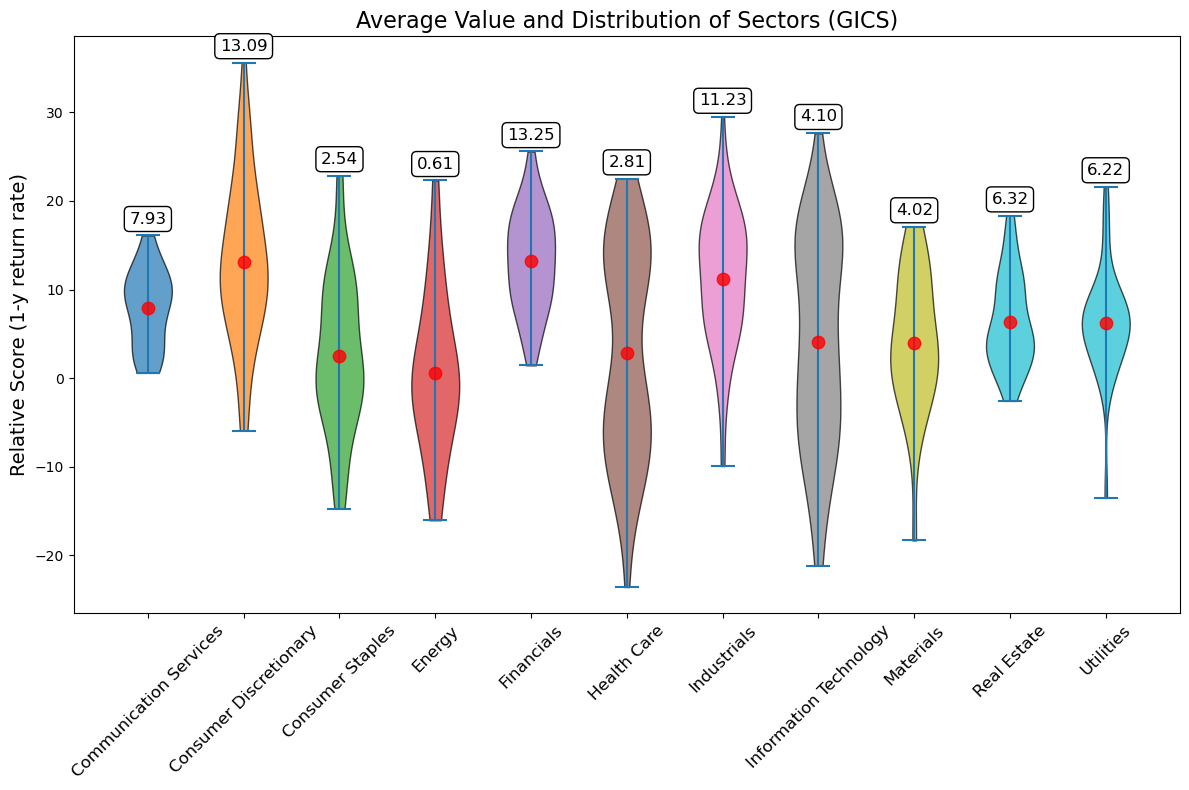

In [5]:
import collections
data = result_dict
data = collections.OrderedDict(sorted(data.items()))

colors = plt.cm.tab10(range(len(data)))
categories = list(data.keys())
values = list(data.values())
means = [np.mean(v) for v in values]
maxs = [np.max(v) for v in values]


plt.figure(figsize=(12, 8))
parts = plt.violinplot(values, showmeans=False, showextrema=True, showmedians=False)

for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

plt.scatter(range(1, len(categories) + 1), means, s=80, alpha=0.8, color='red', label='Mean Values', zorder=3)
for i, mean in enumerate(means):
    plt.text(
        i+1, maxs[i]+1, f'{mean:.2f}', 
        color='black', ha='center', va='bottom', fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')
    )
    
plt.xticks(ticks=np.arange(1, len(categories) + 1), labels=categories, rotation=45, fontsize=12)
plt.title('Average Value and Distribution of Sectors (GICS)', fontsize = 16)
plt.ylabel('Relative Score (1-y return rate)', fontsize = 14)
plt.tight_layout()